In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#import xgboost as xgb
#import lightgbm as lgb
import shap
!pip install xgboost
!pip install lightgbm 
!pip install shap

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/150.0 MB 2.1 MB/s eta 0:01:12
   ---------------------------------------- 1.0/150.0 MB 2.1 MB/s eta 0:01:12
   ---------------------------------------- 1.6/150.0 MB 2.1 MB/s eta 0:01:10
    --------------------------------------- 2.1/150.0 MB 2.1 MB/s eta 0:01:10
    --------------------------------------- 2.6/150.0 MB 2.1 MB/s eta 0:01:10
    --------------------------------------- 2.9/150.0 MB 2.1 MB/s eta 0:01:11
    --------------------------------------- 3.1/150.0 MB 2.1 MB/s eta 0:01:11
    --------------------------------------- 3.1/150.0 MB 2.1 MB/s eta 0:01:11
    --------------------------------------- 3.4/150.0 MB 1.7 MB/s eta 0:01:28
    --------------------------------------- 3.7/150.0 MB 1.6 MB/s eta 0:01:32
   - -------------------------------------- 4.2/150.0 MB 1.6 MB/s eta 0:01:29


In [ ]:
# --- Load & Preprocess Data ---
df_orig = pd.read_csv('AmesHousing.csv')
df_orig.drop(['PID', 'Order'], axis=1, inplace=True)
df_orig.head()
df_orig.describe()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,2929.000000,2929.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,442.629566,49.722431,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,455.590839,169.168476,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,370.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,734.000000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [ ]:
# Handle missing values
def preprocess_data(df):
    # Drop columns with >80% missing values
    threshold = 0.80
    missing_percent = df.isnull().mean()
    cols_to_drop = missing_percent[missing_percent > threshold].index.tolist()
    df = df.drop(columns=cols_to_drop)
    
    # Impute missing values
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    return df

df_cleaned = preprocess_data(df_orig)

C:\Users\nithi\AppData\Local\Temp\ipykernel_21444\3490478585.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\nithi\AppData\Local\Temp\ipykernel_21444\3490478585.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [33]:
# One-Hot Encoding for categorical variables
categorical_cols = df_cleaned.select_dtypes(include='object').columns.tolist()
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

In [49]:
# Train/Test Split
X = df_encoded.drop(columns=['SalePrice'])
y = df_encoded['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

!pip install xgboost lightgbm shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb  
import lightgbm as lgb
import shap




In [55]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [59]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgb_model.fit(X_train, y_train)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3710
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 176
[LightGBM] [Info] Start training from score 178582.207765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, max_depth=5,
              n_estimators=1000, random_state=42, subsample=0.8)

In [61]:
# Evaluation function
def evaluate_model(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "R²": r2}

# Evaluate both models
results = [
    evaluate_model(xgb_model, "XGBoost (All Features)", X_test, y_test),
    evaluate_model(lgb_model, "LightGBM (All Features)", X_test, y_test)
]

results_df = pd.DataFrame(results)
print(results_df)

                     Model           MAE          RMSE        R²
0   XGBoost (All Features)  14286.720323  23983.233021  0.928258
1  LightGBM (All Features)  15331.889769  26107.864903  0.914984


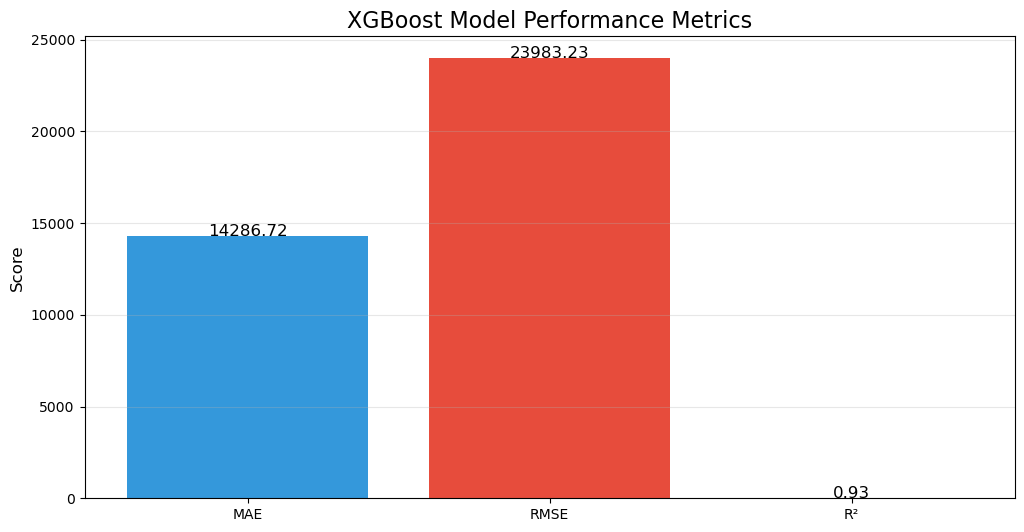

In [63]:
# 1. Performance Metrics Visualization
plt.figure(figsize=(12, 6))
metrics = ['MAE', 'RMSE', 'R²']
values = [
    mean_absolute_error(y_test, xgb_model.predict(X_test)),
    np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test))),
    r2_score(y_test, xgb_model.predict(X_test))
]

colors = ['#3498db', '#e74c3c', '#2ecc71']
plt.bar(metrics, values, color=colors)
plt.title('XGBoost Model Performance Metrics', fontsize=16)
plt.ylabel('Score', fontsize=12)
for i, v in enumerate(values):
    plt.text(i, v+0.01, f"{v:.2f}", ha='center', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()



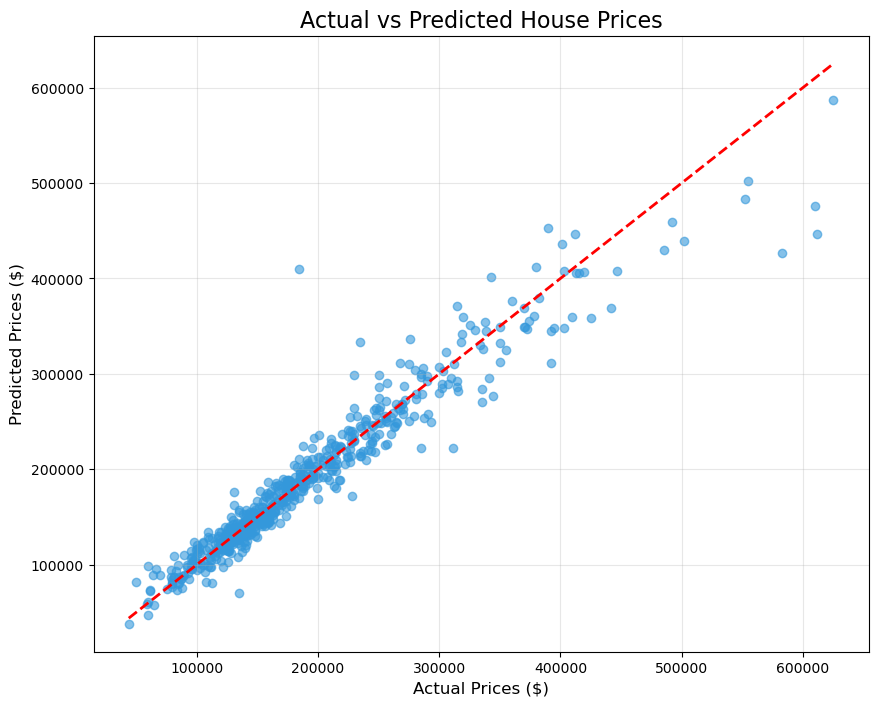

In [65]:
# 2. Actual vs Predicted Prices
plt.figure(figsize=(10, 8))
plt.scatter(y_test, xgb_model.predict(X_test), alpha=0.6, color='#3498db')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted House Prices', fontsize=16)
plt.xlabel('Actual Prices ($)', fontsize=12)
plt.ylabel('Predicted Prices ($)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()



<Figure size 1200x800 with 0 Axes>

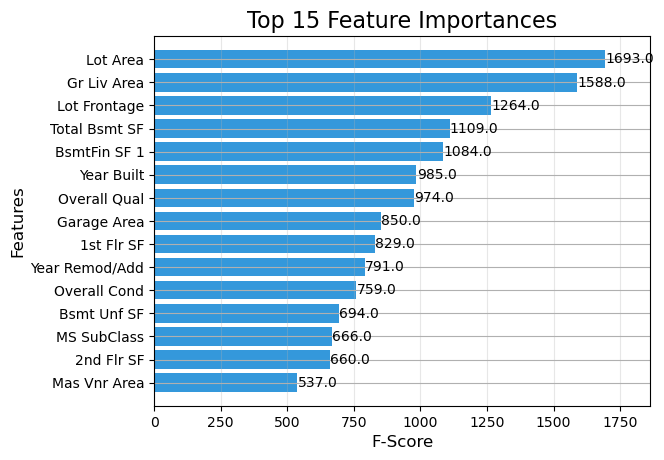

In [67]:
# 3. Feature Importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=15, height=0.8, color='#3498db')
plt.title('Top 15 Feature Importances', fontsize=16)
plt.xlabel('F-Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.show()



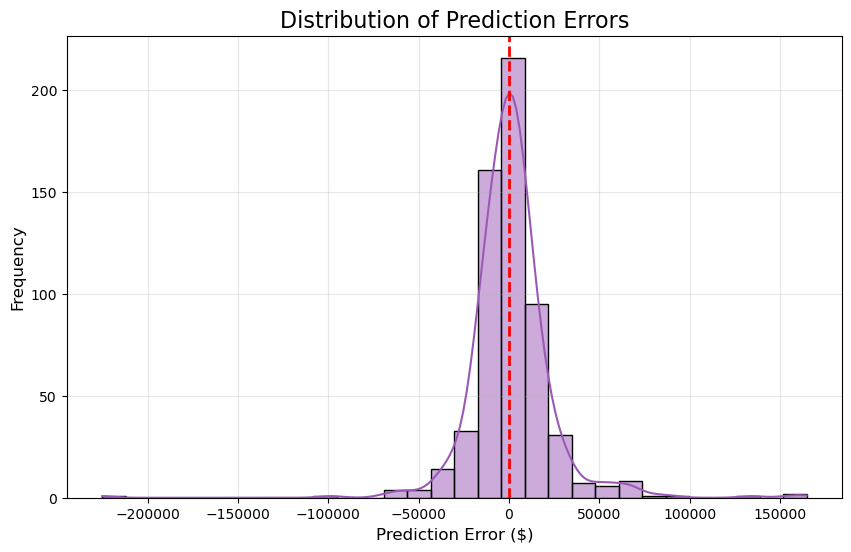

In [77]:
# 5. Error Distribution
errors = y_test - xgb_model.predict(X_test)
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30, color='#9b59b6')
plt.axvline(x=0, color='r', linestyle='--', lw=2)
plt.title('Distribution of Prediction Errors', fontsize=16)
plt.xlabel('Prediction Error ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)
plt.show()



SHAP values shape: (586, 249)
First SHAP values sample:
[ 2.83454346e+02  1.37313553e+02 -1.00326982e+04  4.93618906e+04
  3.99476025e+03 -3.73795850e+03  1.63911060e+03 -2.37137436e+02
 -8.38071387e+03 -6.81176910e+01 -1.27254150e+02 -6.62170312e+03
 -8.06936279e+03  1.24283972e+03  5.68670940e+00 -1.48813489e+03
 -2.07874878e+03 -9.40472507e+00 -8.37785522e+02 -2.76912689e+02
 -5.28811607e+01  1.71692333e+01 -9.90549088e+01  2.85751855e+03
 -1.29446558e+03 -6.57374023e+03 -6.12854688e+03  2.38619461e+01
 -4.75909805e+01 -7.06056290e+01 -3.29061913e+00 -4.92033813e+02
 -4.13129616e+01 -5.32168436e+00  3.18427399e+02 -5.91420212e+01
  1.26468525e+01 -1.54570526e+02  0.00000000e+00 -2.08851433e+00
 -7.92087036e+02 -2.15558154e+03  4.24520445e+00 -2.84173126e+01
  3.31156588e+00 -8.42262192e+01 -9.81812057e+01 -1.59788418e+01
 -3.20424156e+01  0.00000000e+00  0.00000000e+00 -7.08984756e+01
  6.31747198e+00  2.47307956e-01  1.10873785e+01 -3.08602333e+01
 -1.04380369e-01  0.00000000e+00  

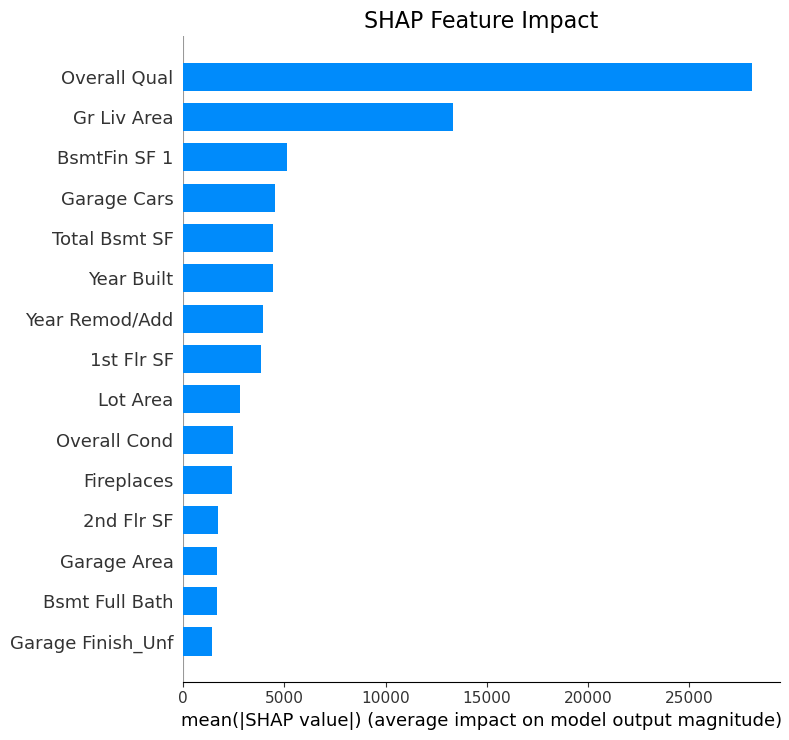

In [ ]:
# 1. Install SHAP
!pip install shap --upgrade

# 2. Calculate SHAP values properly
import shap
shap.initjs()  # Initialize JS visualization (for notebooks)

# Create explainer and calculate values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# 3. Verify SHAP values were calculated
print(f"SHAP values shape: {np.array(shap_values).shape}")  # Should match X_test shape
print(f"First SHAP values sample:\n{shap_values[0]}")  # Should show non-zero values

# 4. Create the summary plot with proper settings
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values, 
    X_test,
    plot_type="bar",
    max_display=15,
    show=False  
)
plt.title("SHAP Feature Impact", fontsize=16)
plt.tight_layout()

# 5. Alternative visualization
if len(plt.gca().get_children()) == 0:  # Check if plot is empty
    print("\n⚠️ Primary visualization failed - trying alternative approach")
    
    # Calculate mean absolute SHAP values
    shap_df = pd.DataFrame({
        'features': X_test.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values('mean_abs_shap', ascending=False).head(15)
    
    # Create bar plot
    plt.figure(figsize=(12, 8))
    plt.barh(shap_df['features'], shap_df['mean_abs_shap'], color='#3498db')
    plt.title("Feature Impact (Mean |SHAP|)", fontsize=16)
    plt.xlabel("Mean Absolute SHAP Value", fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.gca().invert_yaxis()

plt.show()

SHAP version: 0.47.1

SHAP values verification:
Shape: (586, 249)
Non-zero values: 116028 / 145914
Sample values:
 [   283.45435    137.31355 -10032.698    49361.89      3994.7603 ]


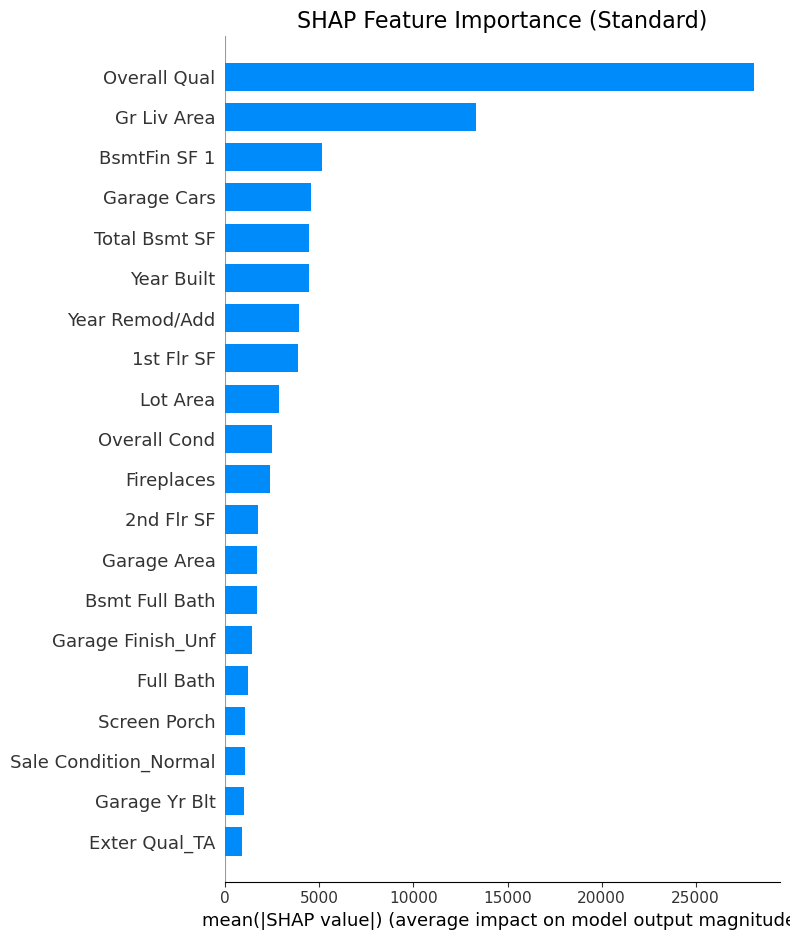

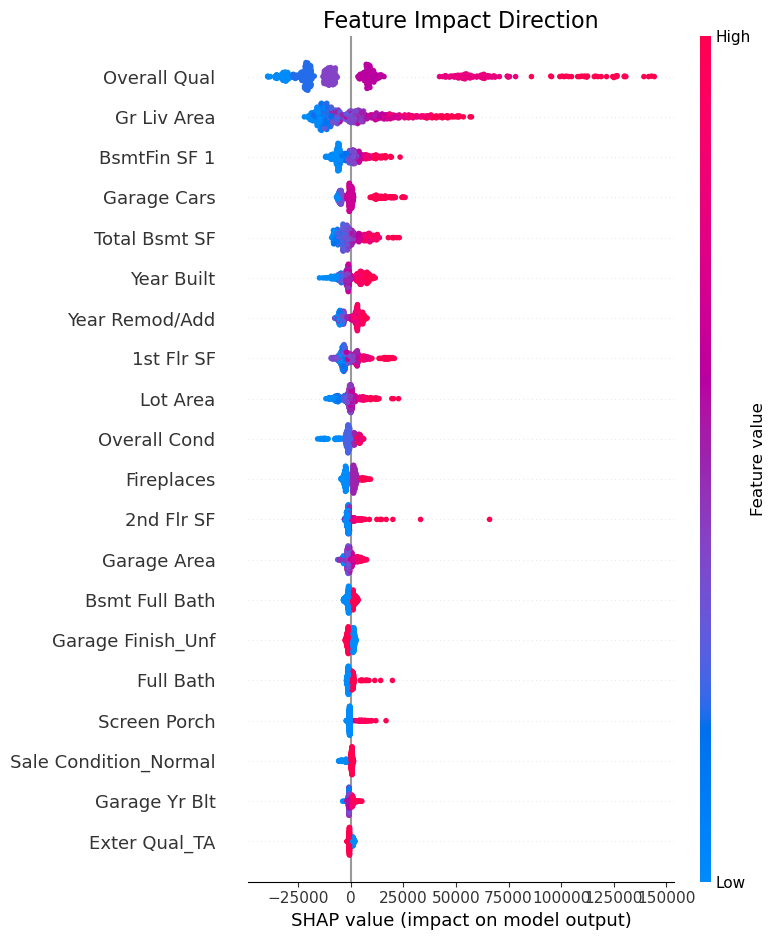

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Initialize SHAP and verify installation
try:
    shap.initjs()
    print("SHAP version:", shap.__version__)
except Exception as e:
    !pip install --upgrade shap
    import shap
    shap.initjs()

# 2. Calculate SHAP values correctly
def get_shap_values(model, X):
    try:
        # Try TreeExplainer first (for tree models)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
    except:
        # KernelExplainer
        background = shap.sample(X, 100)
        explainer = shap.KernelExplainer(model.predict, background)
        shap_values = explainer.shap_values(X)
    
    return explainer, shap_values

explainer, shap_values = get_shap_values(xgb_model, X_test)

# 3. Verify SHAP values
print("\nSHAP values verification:")
print("Shape:", np.array(shap_values).shape)
print("Non-zero values:", np.count_nonzero(shap_values), "/", np.size(shap_values))
print("Sample values:\n", shap_values[0][:5])  # First row, first 5 features

# 4. Create visualizations
plt.figure(figsize=(12, 8))

#  Standard SHAP summary plot
try:
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance (Standard)", fontsize=16)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("\nStandard SHAP plot failed:", str(e))
    
    # Option 2: Manual bar plot
    mean_abs_shap = pd.DataFrame({
        'features': X_test.columns,
        'importance': np.abs(shap_values).mean(axis=0)
    }).sort_values('importance', ascending=False).head(15)
    
    plt.figure(figsize=(12, 8))
    plt.barh(mean_abs_shap['features'], mean_abs_shap['importance'], color='#3498db')
    plt.title("Feature Impact (Mean Absolute SHAP)", fontsize=16)
    plt.xlabel("Mean |SHAP Value|", fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.show()

# 5. Beeswarm plot for detailed analysis
plt.figure(figsize=(12, 8))
try:
    shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
    plt.title("Feature Impact Direction", fontsize=16)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("\nBeeswarm plot failed:", str(e))